# Churn Prediction System

**Importing the packages**

In [1]:
#!pip install -U imbalanced-learn==0.12.3 scikit-learn==1.2.2 numpy==1.26.4 --quiet


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split ,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report,f1_score
import pickle

**Loading the dataset and exploring the features**

In [3]:
# Loading the dataset(Telco Customer Dataset)
data=pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Data Cleaning**

In [4]:
#Data Cleaning
data=data.drop(columns=['customerID'])
data['TotalCharges'] = data['TotalCharges'].replace({" ":"0.0"}).astype(float)


In [5]:
#displaying the unique values in all columns
numeric_cols= data.select_dtypes(include=['number']).columns
continuous_features = [ col for col in numeric_cols if data[col].nunique() > 2]
print("Continuous Features: ",continuous_features)
print("Unique Values in all columns")
for col in data.columns:
    if col not in continuous_features:
        print(col, data[col].unique())
      

Continuous Features:  ['tenure', 'MonthlyCharges', 'TotalCharges']
Unique Values in all columns
gender ['Female' 'Male']
SeniorCitizen [0 1]
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


**Data Analysis**

            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


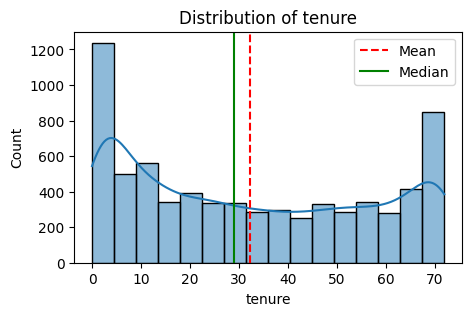

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


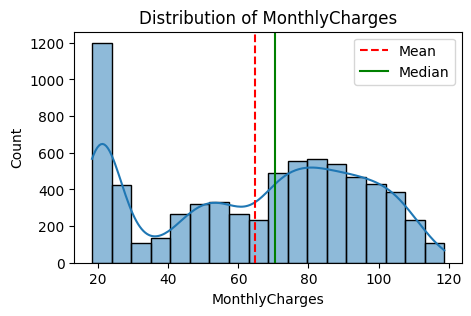

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


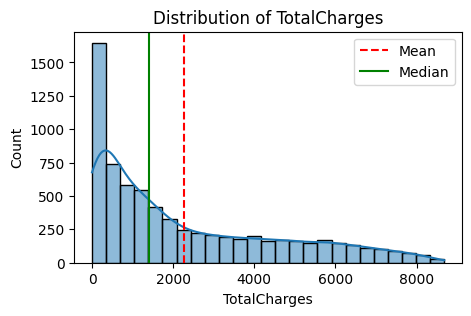

In [6]:
#Data analysis
print(data[continuous_features].describe())

#defining histogram function to visualize the continuous value features
def plot_histogram(data, column_name):

  plt.figure(figsize=(5, 3))
  sns.histplot(data[column_name], kde=True)
  plt.title(f"Distribution of {column_name}")

  # calculate the mean and median values for the columns
  col_mean = data[column_name].mean()
  col_median = data[column_name].median()

  # add vertical lines for mean and median
  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend()

  plt.show()

#visualizing the distribution of continuous features in dataset
for col in continuous_features:
    plot_histogram(data,col)



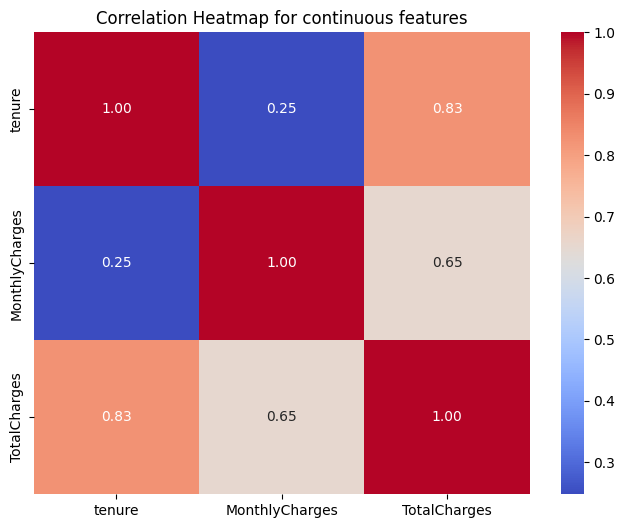

In [7]:
#Correlation HeatMap for continuous features
plt.figure(figsize=(8, 6))
sns.heatmap(data[continuous_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap for continuous features")
plt.show()

**Data Analysis of Categorical Features**

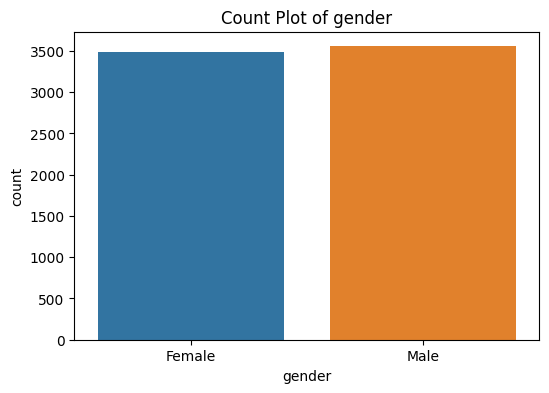

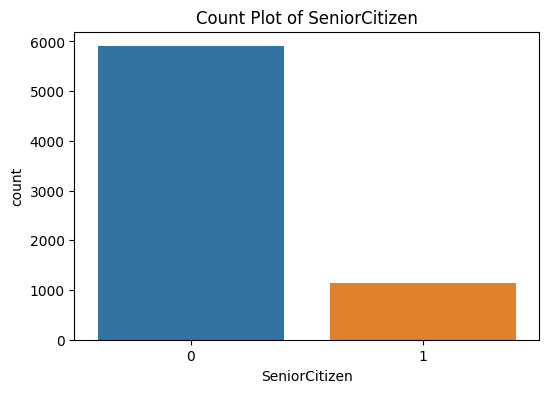

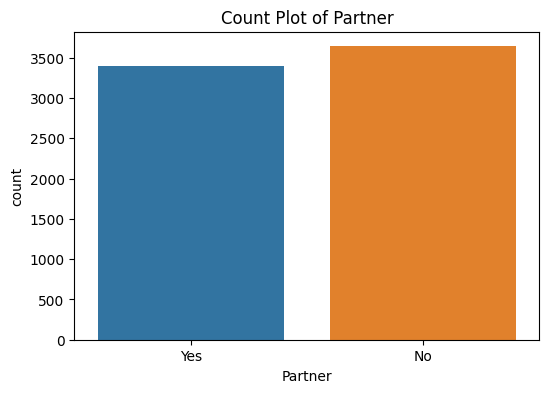

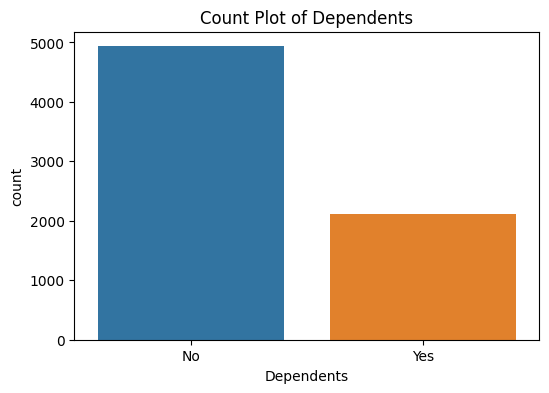

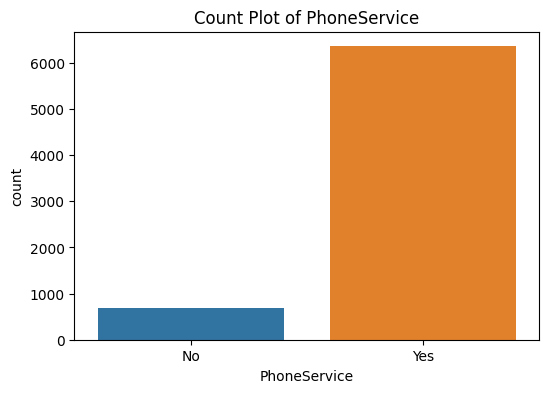

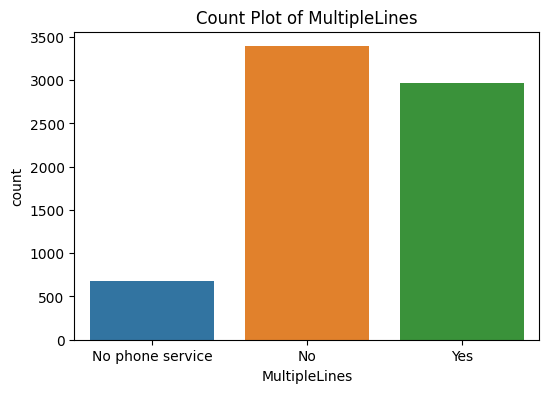

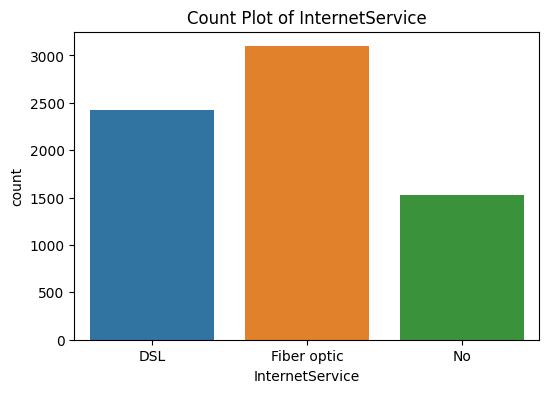

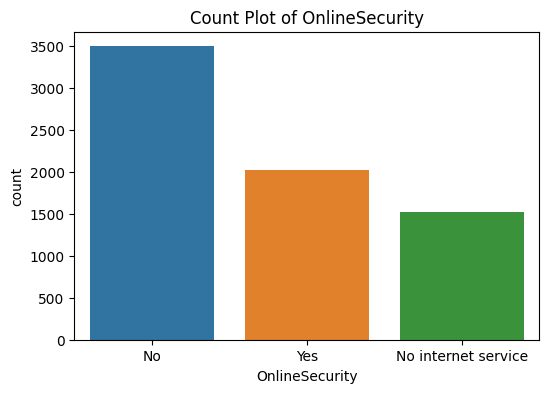

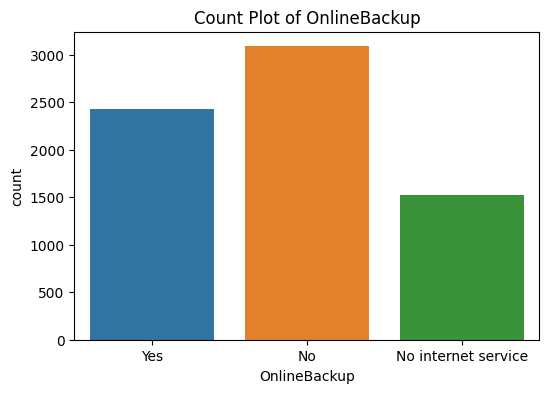

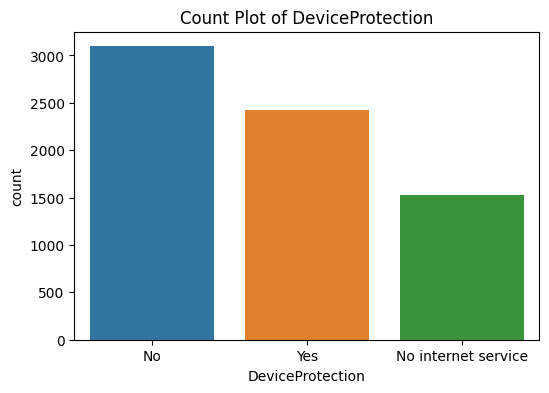

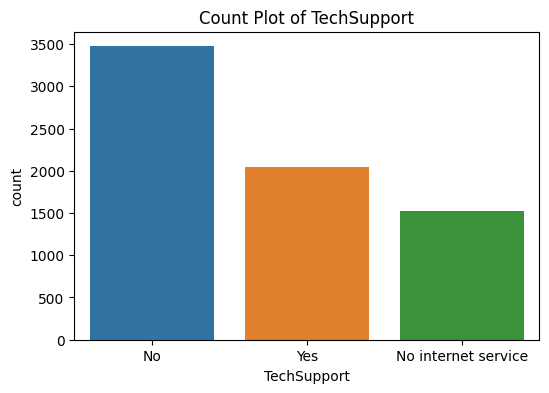

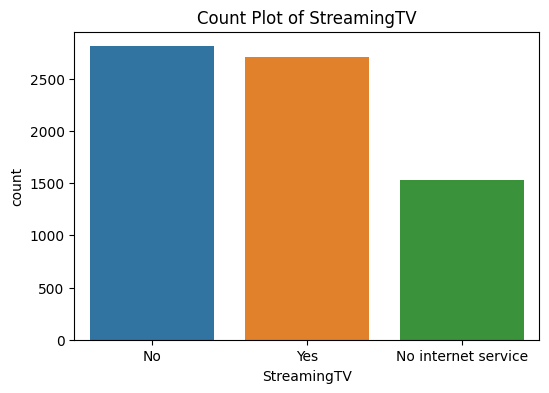

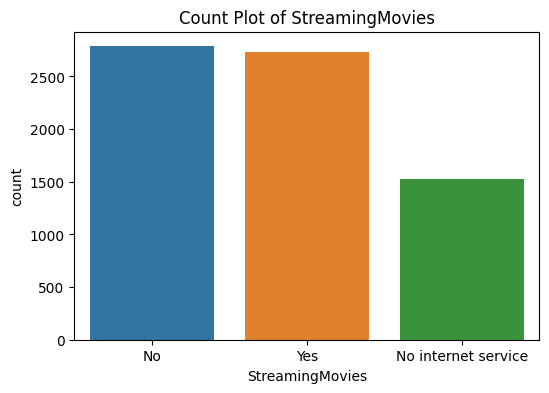

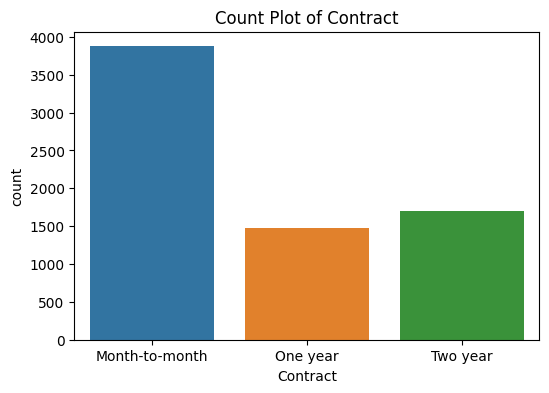

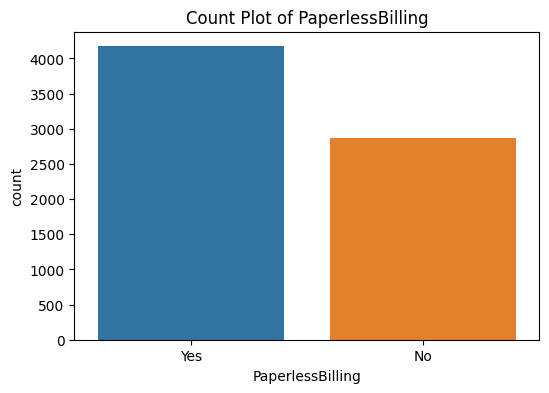

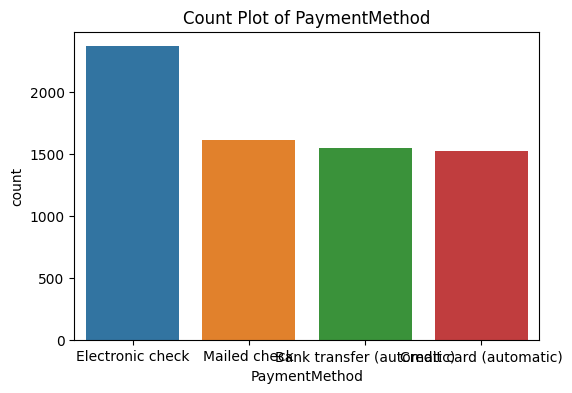

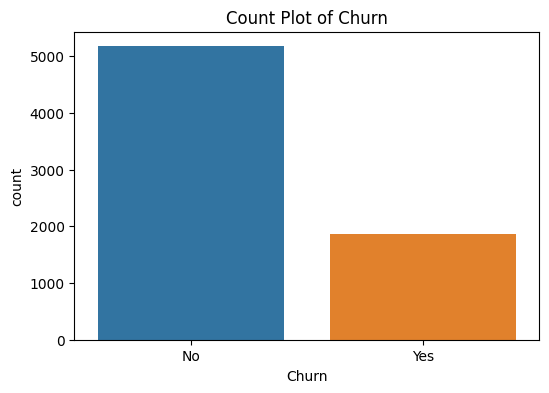

In [8]:
#visualizing the count plot for categorical features
categorical_features=data.drop(columns=continuous_features).columns

for col in categorical_features:
  plt.figure(figsize=(6, 4))
  sns.countplot(x=data[col])
  plt.title(f"Count Plot of {col}")
  plt.show()

**Data preprocessing**

In [9]:
#converting yes, no into 0,1 fr target feature
data["Churn"] = data["Churn"].replace({"Yes": 1, "No": 0})

#identifying columns with object datatype for data transformation
object_cols = data.select_dtypes(include='object').columns
print(object_cols)

Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod'],
      dtype='object')


/tmp/ipykernel_117/2172854682.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Churn"] = data["Churn"].replace({"Yes": 1, "No": 0})


In [10]:
# initialize a dictionary to save the encoders
encoders = {}

# apply label encoding and store the encoders
for column in object_cols:
  label_encoder = LabelEncoder()
  data[column] = label_encoder.fit_transform(data[column])
  encoders[column] = label_encoder


# save the encoders to a pickle file
with open("encoders.pkl", "wb") as f:
  pickle.dump(encoders, f)

data.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.50,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1


In [11]:
#saving the cleaned dataset for visualizing in dashboard
data.to_csv("cleaned_telco_churn.csv", index=False)

**Training and Testing the data Split**

In [12]:
#splitting the data into features and target
X=data.drop(columns=['Churn'])
Y=data['Churn']

#Splitting the data into train and test
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)


**Analysing the values of target variable**

In [13]:
print(Y_train.shape)
print(Y_train.value_counts())

(4930,)
Churn
0    3635
1    1295
Name: count, dtype: int64


**We Apply Synthetic Minority Oversampling Technique(SMOTE) for equal distribution of target samples**

* we only transform the train data to equal distribute the samples

In [14]:
#initializing the SMOTE variable
smote = SMOTE(random_state=42)

X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)

print(Y_train_smote.shape)
print(Y_train_smote.value_counts())

(7270,)
Churn
0    3635
1    3635
Name: count, dtype: int64


**Mode Training**

In [15]:
# dictionary of models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# dictionary to store the cross validation results
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name, model in models.items():
  print(f"Training {model_name} with default parameters")
  scores = cross_val_score(model, X_train_smote, Y_train_smote, cv=5, scoring="accuracy")
  cv_scores[model_name] = scores
  print(f"{model_name} cross-validation accuracy: {np.mean(scores):.2f}")
  print("-"*60)

results = {
    "Model": ["Decision Tree", "Random Forest", "XGBoost"],
    "CV Accuracy": [np.mean(cv_scores["Decision Tree"]),
                    np.mean(cv_scores["Random Forest"]),
                    np.mean(cv_scores["XGBoost"])]
}
pd.DataFrame(results).to_csv("model_results.csv", index=False)

print(f'CV Scores\n{cv_scores}')

Training Decision Tree with default parameters
Decision Tree cross-validation accuracy: 0.79
------------------------------------------------------------
Training Random Forest with default parameters
Random Forest cross-validation accuracy: 0.84
------------------------------------------------------------
Training XGBoost with default parameters
XGBoost cross-validation accuracy: 0.83
------------------------------------------------------------
CV Scores
{'Decision Tree': array([0.67675378, 0.7303989 , 0.83631362, 0.83425034, 0.85694635]), 'Random Forest': array([0.72145805, 0.78335626, 0.89339752, 0.9002751 , 0.90302613]), 'XGBoost': array([0.71664374, 0.74896836, 0.90371389, 0.89614856, 0.9085282 ])}


**Model Training and Evaluation**
* As Random Forest Classifier is giving high accuracy compared to other, we consider the RandomForestClassifier() to evaluate and predict

In [16]:
#Initializing the model
rfc = RandomForestClassifier(random_state=42)

#Training the model with train data which is transformed with equal distribution
rfc.fit(X_train_smote, Y_train_smote)

#evaluate on test data
Y_test_pred = rfc.predict(X_test)
pred_prob= rfc.predict_proba(X_test)

print("prediction: ",Y_test_pred)
print("prediction probability: ",pred_prob)

print("Accuracy Score:\n", accuracy_score(Y_test, Y_test_pred))
print("Confsuion Matrix:\n", confusion_matrix(Y_test, Y_test_pred))
print("Classification Report:\n", classification_report(Y_test, Y_test_pred))

#saving the trained model as pickle file for further use
model_data = { "model": rfc ,"features_names": X.columns}

with open("customer_churn_model.pkl","wb") as f:
    pickle.dump(model_data, f)

feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rfc.feature_importances_
}).sort_values(by="Importance", ascending=False)

feature_importances.to_csv("feature_importance.csv", index=False)

test_results = X_test.copy()
test_results["Actual"] = Y_test
test_results["Predicted"] = Y_test_pred
test_results["PredictProbability"]= pred_prob[:,1]
test_results.to_csv("test_predictions.csv", index=False)

prediction:  [1 0 0 ... 0 1 0]
prediction probability:  [[0.18 0.82]
 [0.85 0.15]
 [1.   0.  ]
 ...
 [0.92 0.08]
 [0.14 0.86]
 [0.82 0.18]]
Accuracy Score:
 0.7695220066256507
Confsuion Matrix:
 [[1299  240]
 [ 247  327]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      1539
           1       0.58      0.57      0.57       574

    accuracy                           0.77      2113
   macro avg       0.71      0.71      0.71      2113
weighted avg       0.77      0.77      0.77      2113



**Building a predictive System using saved trained model**

In [17]:
#loading the saved model and features names from pickle file
with open("customer_churn_model.pkl", "rb") as f:
  model_data = pickle.load(f)

loaded_model = model_data["model"]
feature_names = model_data["features_names"]
print(f'loaded_model: {loaded_model}\nfeature_names: {feature_names}')

#loading the new instance to predict the outcome
input_data = {
    'gender': 'Female',
    'SeniorCitizen': 0,
    'Partner': 'Yes',
    'Dependents': 'No',
    'tenure': 1,
    'PhoneService': 'No',
    'MultipleLines': 'No phone service',
    'InternetService': 'DSL',
    'OnlineSecurity': 'No',
    'OnlineBackup': 'Yes',
    'DeviceProtection': 'No',
    'TechSupport': 'No',
    'StreamingTV': 'No',
    'StreamingMovies': 'No',
    'Contract': 'Month-to-month',
    'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check',
    'MonthlyCharges': 29.85,
    'TotalCharges': 29.85
}

#converting the new instance into dataframe
input_data_df = pd.DataFrame([input_data])

with open("encoders.pkl", "rb") as f:
  encoders = pickle.load(f)


# encode categorical features using the saved encoders
for column, encoder in encoders.items():
  input_data_df[column] = encoder.transform(input_data_df[column])

# make a prediction
prediction = loaded_model.predict(input_data_df)
pred_prob = loaded_model.predict_proba(input_data_df)

print("outcome: ",prediction)

# results
print(f"Prediction: {'Churn' if prediction[0] == 1 else 'No Churn'}")
print(f"Prediciton Probability: {pred_prob}")

loaded_model: RandomForestClassifier(random_state=42)
feature_names: Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')
outcome:  [0]
Prediction: No Churn
Prediciton Probability: [[0.76 0.24]]
